In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.timeseries import LombScargle
import matplotlib.transforms as transforms

from tinygp import kernels
from scipy.stats import loguniform, uniform

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from prettytable import PrettyTable

#from stingray.simulator import simulator
#import random
import jaxns
from scipy.signal import savgol_filter

#from jaxns import ExactNestedSampler
#from jaxns import TerminationCondition
import re

import tensorflow_probability.substrates.jax.distributions as tfpd

from tinygp import GaussianProcess
from functools import partial
import pickle
import warnings
warnings.filterwarnings('ignore')
from pioran import PSDToACV
from pioran.psd import OneBendPowerLaw


INFO[2024-06-25 12:01:15,856]: Unable to initialize backend 'cuda': 
INFO[2024-06-25 12:01:15,857]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2024-06-25 12:01:15,858]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
WARNING[2024-06-25 12:01:15,859]: An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
from THESIS import LightCurveSampler, JAXNSmodelCreator, ModelComparison


In [3]:
def bend_pl(f, norm, f_bend, alph_lo, alph_hi, sharpness):
    # Bending power-law with two slopes, modified from Summons et al. 2007 
    # (http://adsabs.harvard.edu/abs/2007MNRAS.378..649S)
    # to include 'sharpness' parameter.  Sharpness = 1 same as simpler Summons et al. model, larger values
    # give a sharper transition from one slope to the other.
    # Typical slopes for AGN would be alph_lo=-1, alph_hi=-2 to -3
    powmod = (norm*(f/f_bend)**alph_lo)/(1.+(f/f_bend)**(sharpness*(alph_lo-alph_hi)))**(1./sharpness)
    return powmod


def bend_pl_lorentz(f, norm, f_bend, alph_lo, alph_hi, sharpness, lor_rmssq, f_pk, q):
    f_res=f_pk/np.sqrt(1.0+(1.0/(4.0*q**2)))
    r=np.sqrt(lor_rmssq)/np.sqrt(0.5-np.arctan(-2.0*q)/np.pi)
    powmod_lorentz = ((1/np.pi)*2*r**2*q*f_res)/(f_res**2+(4*q**2*np.square(f-f_res)))
    
    powmod_bend_pl = (norm*(f/f_bend)**alph_lo)/(1.+(f/f_bend)**(sharpness*(alph_lo-alph_hi)))**(1./sharpness)
    
    return powmod_bend_pl+powmod_lorentz

49159
97889


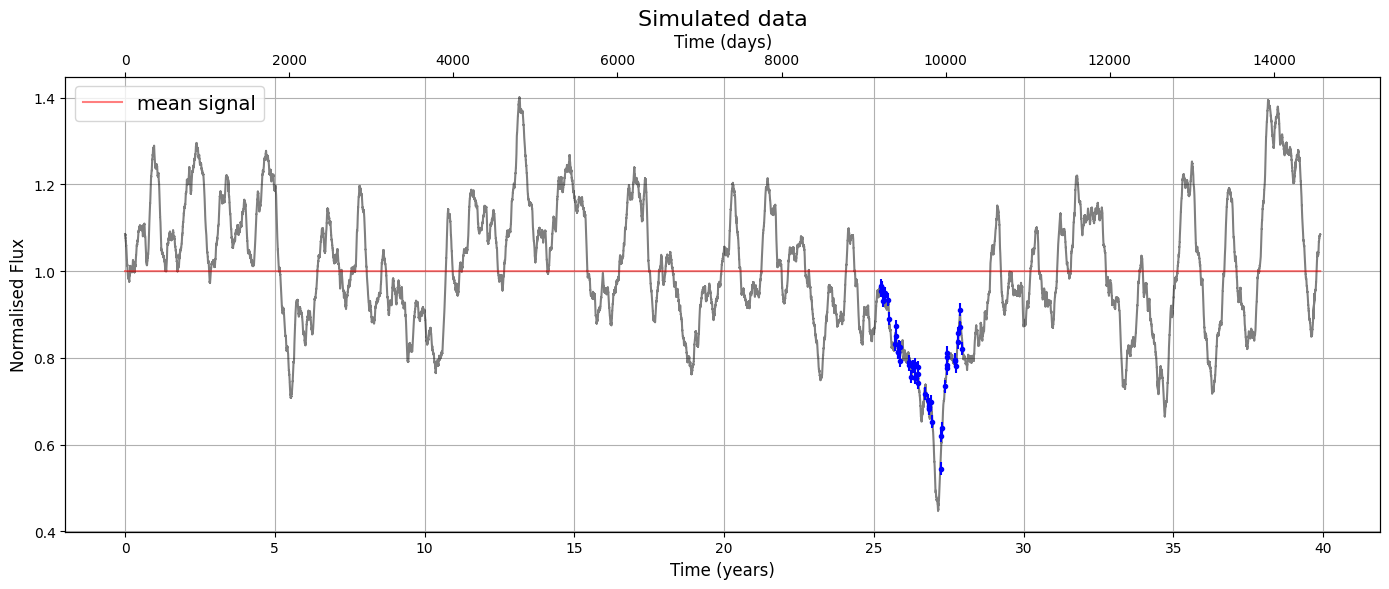

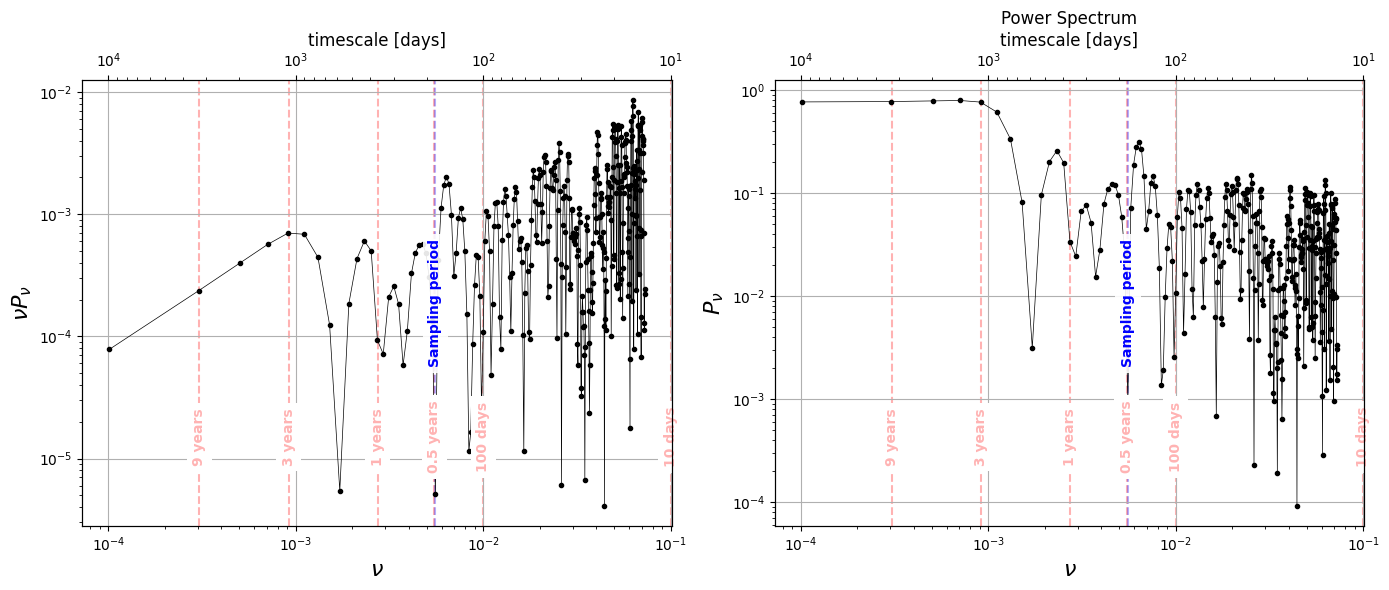

In [4]:
np.random.seed()
rand =  np.random.randint(0, 100000)
print(rand)
l = LightCurveSampler(N=2**21, rms=0.15, simulatorSEED= rand ,mean = partial(sin_curve, 0.15*row.A1, row.period, 0),  verbose=False)
l.load_powerspec(bend_pl, [200,  1/365,  -1,-3,10], plot=False)
l.LCsimulator()
np.random.seed() 
rand =  97889 #np.random.randint(0, 100000)

print(rand)
simTIME, simLC, simLCerr , lc = l.sampler(NightsperWINDOW = 10, NumofWINDOW = 6 , OBSperiod = 6, WINDOWwidth =120, samplerSEED=rand,
                                        dataLOSSfrac=0.2, noiseSIGMA=0.015, plot=True)


<ErrorbarContainer object of 3 artists>

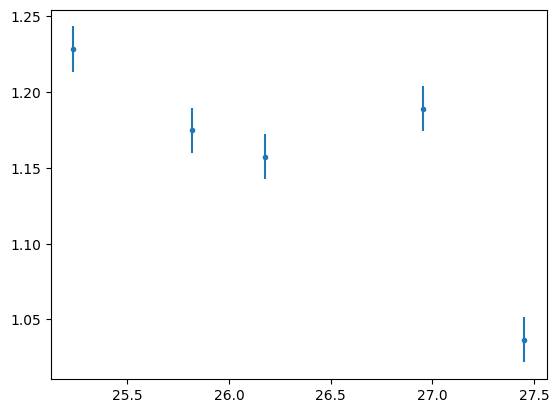

In [6]:
plt.errorbar(simTIME, simLC, yerr = simLCerr, fmt ='.')

In [23]:
from tinygp import kernels
from tinygp import GaussianProcess

import jax

jax.config.update("jax_enable_x64", True)



In [92]:
# Simulate a made up dataset, as an example
random = np.random.default_rng(np.random.randint(0, 1000))
X = simTIME# np.sort(random.uniform(0, 10, 5))
y = simLC #np.sin(X) + 1e-4 * random.normal(size=X.shape)
y_err =  simLCerr# np.ones_like(X)*0.1

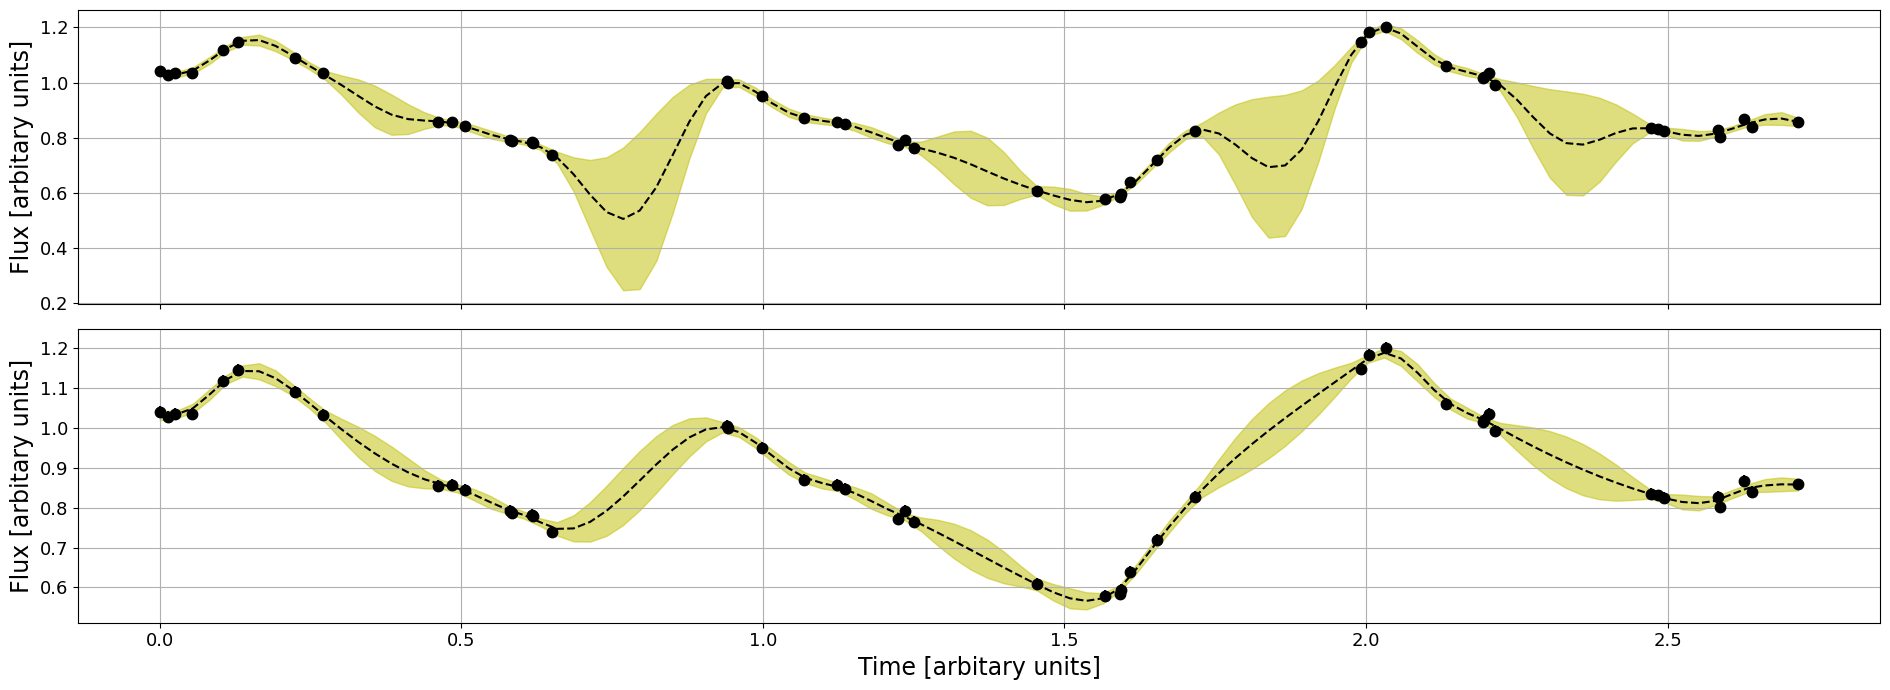

In [91]:
X_test = np.linspace(min(X), max(X), 100)
fig, ax =  plt.subplots(2, 1 , figsize = [19, 7], sharex = True)



kernel = 0.5 * kernels.ExpSquared(scale=0.11)
gp = GaussianProcess(kernel, X, diag=y_err**2)
_, cond_gp = gp.condition(y, X_test)
mu = cond_gp.mean
std = np.sqrt(cond_gp.variance)

ax[0].plot(X_test-X[0], mu, "k--")
ax[0].fill_between(X_test-X[0],mu - std, mu + std, color = 'y', alpha = 0.5)

ax[0].errorbar(X-X[0], y, yerr = y_err,  fmt = ".", color = 'k',markersize = 15,  label = 'data')
#ax[0].set_xlim(X_test.min(), X_test.max())
#ax[0].set_xlabel("x")
ax[0].set_ylabel("Flux [arbitary units]", fontsize = 17)
ax[0].grid()
ax[0].tick_params(labelsize= 13)

kernel = 0.5 * kernels.Matern32(scale=0.70)
gp = GaussianProcess(kernel, X, diag=y_err**2)
_, cond_gp = gp.condition(y, X_test)
mu = cond_gp.mean
std = np.sqrt(cond_gp.variance)

ax[1].plot(X_test-X[0], mu, "k--")
ax[1].fill_between(X_test-X[0],mu - std, mu + std, color = 'y', alpha = 0.5)

ax[1].errorbar(X-X[0], y,yerr = y_err,  fmt = ".", color = 'k',markersize = 15,  label = 'data')
#ax[1].set_xlim(X_test.min(), X_test.max())
#ax[0].set_xlabel("x")
ax[1].set_ylabel("Flux [arbitary units]", fontsize = 17)
ax[1].set_xlabel("Time [arbitary units]", fontsize = 17)
ax[1].grid()
ax[1].tick_params(labelsize= 13)


plt.tight_layout()
plt.show()

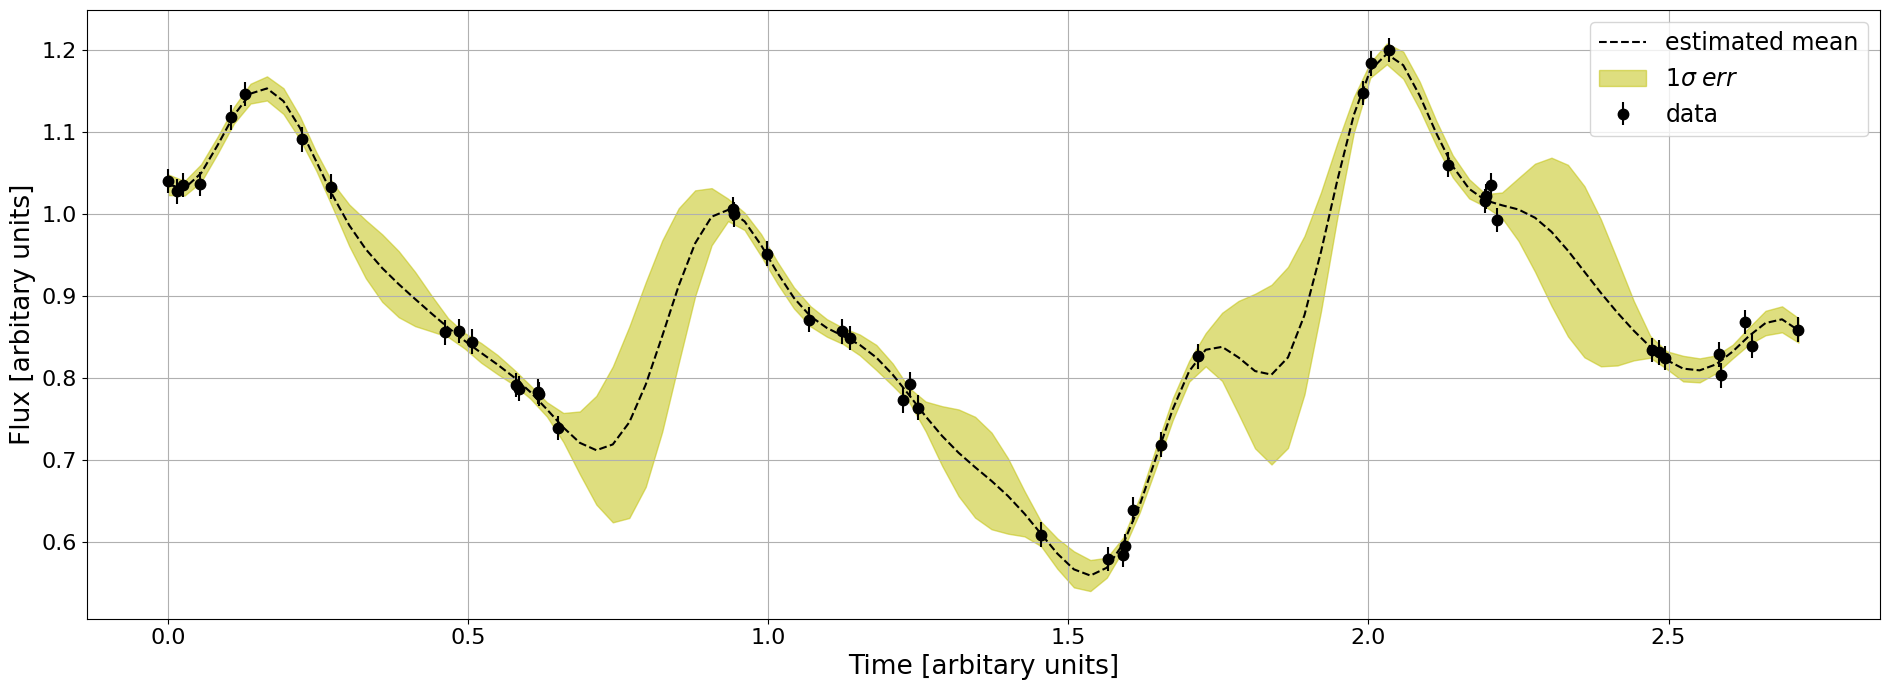

In [70]:
X_test = np.linspace(min(X), max(X), 100)
fig, ax =  plt.subplots(1, 1 , figsize = [19, 7], sharex = True)



kernel = 0.5 * kernels.ExpSquared(scale=0.14)
gp = GaussianProcess(kernel, X, diag=y_err**2)
_, cond_gp = gp.condition(y, X_test)
mu = cond_gp.mean
std = np.sqrt(cond_gp.variance)

ax.plot(X_test-X[0], mu, "k--", label = 'estimated mean')
ax.fill_between(X_test-X[0],mu - std, mu + std, color = 'y', alpha = 0.5, label = '$1\sigma\; err$')

ax.errorbar(X-X[0], y,yerr = y_err,  fmt = ".", color = 'k',markersize = 15,  label = 'data')
plt.legend(fontsize = 17)
#ax.set_xlim(X_test.min(), X_test.max())
#ax[0].set_xlabel("x")
ax.set_ylabel("Flux [arbitary units]", fontsize = 19)
ax.set_xlabel("Time [arbitary units]", fontsize = 19)
ax.grid()
ax.tick_params(labelsize= 16)

plt.tight_layout()
plt.show()

In [ ]:
lc.counts_err = np.abs(np.random.normal(0.015, 0.005, len(lc.counts)))#np.ones(len(lc.counts))*0.015

counts = lc.counts + np.abs(np.random.normal(0.015, 0.0015, len(lc.counts)))

In [ ]:
from scipy.optimize import curve_fit
def sine_function(x, A, B, C, D):
    return A * np.sin(2*np.pi* x/B + C) + D

0.1297429806168198 0.7964136230560366 -0.5366368161346774 0.00994550138285759


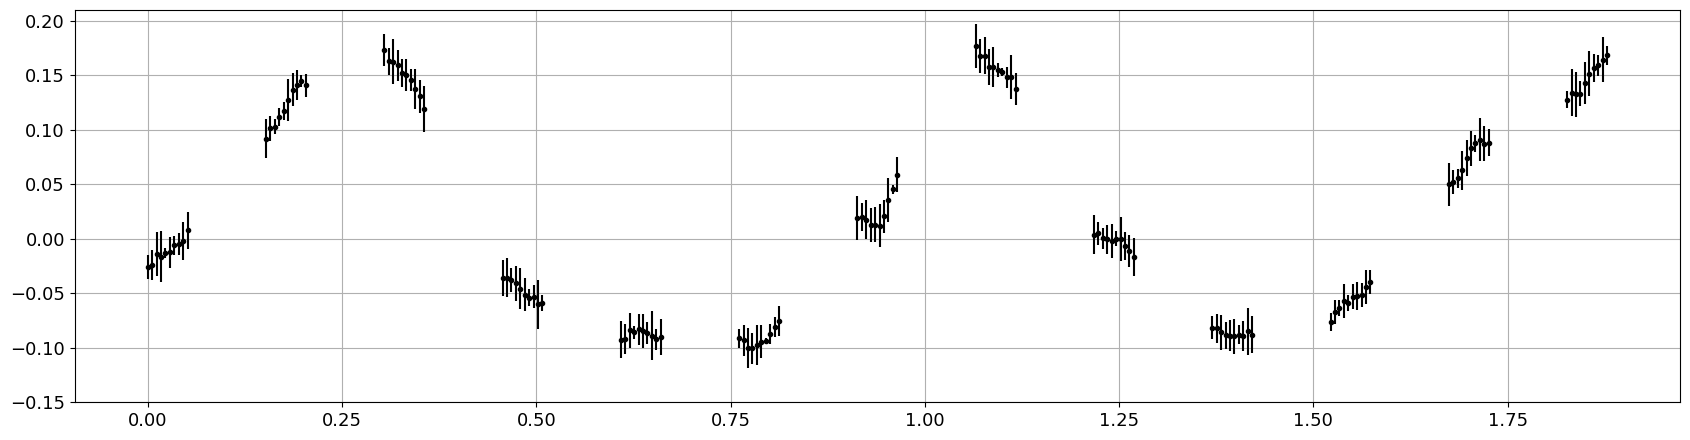

In [ ]:
plt.figure(figsize=[17,4.5])
dx = 3000
time_array = np.array([])
flux_array = np.array([])
flux_err_array = np.array([])
for val in np.arange(995000, 1100000-5000, 8000):#[995000, 1000000, 1005000, 1005000]:
    time = lc.time[np.arange(val,val + dx,300).astype('int')]
    flux = counts[np.arange(val,val + dx,300).astype('int')]
    fluxerr= lc.counts_err[np.arange(val,val + dx,300).astype('int')]
    
    
    time_array = np.concatenate((time_array, time))
    flux_array = np.concatenate((flux_array, flux))
    flux_err_array = np.concatenate((flux_err_array, fluxerr))
#plt.plot(lc.time[np.arange(980000,1150000,1).astype('int')], lc.counts[np.arange(980000,1150000,1).astype('int')], 'k,')

plt.errorbar((time_array - time_array[0])/365, flux_array - np.median(flux_array), yerr=flux_err_array, fmt = '.', color = 'k')
initial_guess = [.2, 1, -.5, 0]

params, params_covariance = curve_fit(sine_function, (time_array -time_array[0])/365, flux_array - np.median(flux_array), p0=initial_guess, sigma=flux_err_array, absolute_sigma=True)

A, B, C, D = params
param_errors = np.sqrt(np.diag(params_covariance))

x_fit = np.linspace(0, np.array((time_array-time_array[0])/365)[-1], 500)
y_fit = sine_function(x_fit, *params)

fit_curve_jacobian = np.array([np.sin(B * x_fit + C), A * x_fit * np.cos(B * x_fit + C), A * np.cos(B * x_fit + C), np.ones_like(x_fit)]).T
y_fit_error = np.sqrt(np.sum((fit_curve_jacobian @ params_covariance) * fit_curve_jacobian, axis=1))*3


print(A, B, C, D)
x = np.linspace(0, np.array((time_array-time_array[0])/365)[-1], 500)
#plt.plot(x_fit, y_fit)
# plt.plot(x_fit, y_fit, color='blue')
# plt.fill_between(x_fit, y_fit - y_fit_error, y_fit + y_fit_error, color='blue', alpha=0.2)


#plt.errorbar(simTIME, simLC,yerr=simLCerr,fmt ='.', color='k')
#plt.plot(simTIME1, simLC1,'k.')
plt.plot()
#plt.plot(time_array, sin_curve(0.15*2, 1.4, 0, time_array ) + 1, color = 'lawngreen', lw=3, label = 'Periodic component' )
plt.grid()
plt.tick_params(labelsize=13)
#plt.xlabel('$time\;[arbitary\;units]$', fontsize = 30)
#plt.ylabel('$Normalised\;flux$', fontsize = 30)
#plt.legend(fontsize=30)
plt.ylim(-0.15,0.21)
plt.tight_layout()
#plt.savefig('plots/NAC/AGN_Noper_transparent.png', transparent = True)

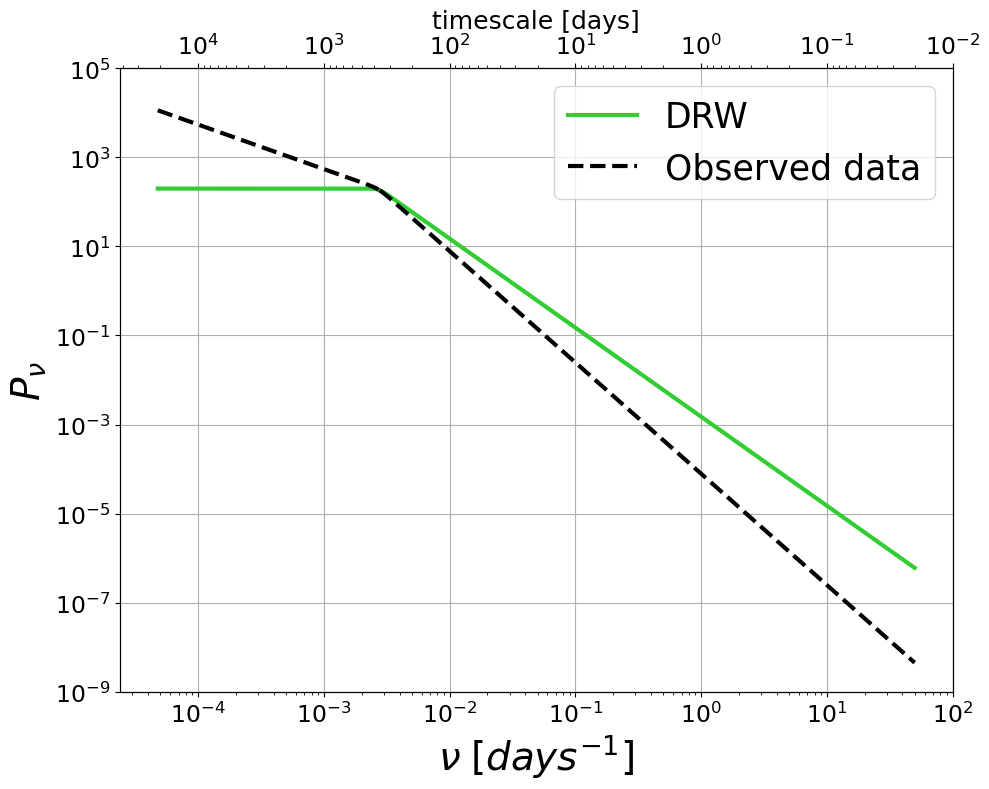

In [ ]:
freq = np.fft.rfftfreq(2**21, d=0.01)[1:]   # [1:] to remove the DC power in the spectrum
spectrum_DRW = bend_pl(freq, 200,  1/365,  -0,-2,10)

spectrum_OBS1 = bend_pl(freq[freq>1/365], 200,  1/365,  -1,-2.5,10)

spectrum_OBS2 = bend_pl(freq[freq<1/365], 200,  1/365,  -1,-2.5,10)

fig, ax = plt.subplots(1,1, figsize=[10,8])
#lc = self.sim.simulate(spectrum)
#plt.plot(lc.time/365, lc.counts, 'g')

ax.set_xscale('log')
ax.set_yscale('log')
#ax[0].set_title('Power spectrum', fontsize=16)
ax.set_ylabel(r'$P_{\nu}$', fontsize=28)
ax.set_xlabel(r'$\nu\;[days^{-1}]$', fontsize=28)
ax.grid()
ax.set_ylim(bottom=10**-9 ,top = 10**5)
ax.tick_params(labelsize=17)
ax_top = ax.twiny()  
ax_top.set_xlabel('timescale [days]', fontsize = 18) 
ax_top.plot(1/freq, spectrum_DRW,'r-', lw=3, alpha=0.0)
ax_top.set_xscale('log')
ax_top.set_yscale('log')


ax.plot(freq, spectrum_DRW,'-', color= 'limegreen', lw=3, label='DRW')
ax.plot(freq[freq>1/365], spectrum_OBS1,'k--', lw=3, label = 'Observed data')
ax.plot(freq[freq<1/365], spectrum_OBS2,'k--', lw=3)

ax_top.tick_params(axis='x', labelsize=17)
ax_top.invert_xaxis()

ax.legend(fontsize=25)
plt.tight_layout()
plt.savefig('plots/NAC/DRW_PSD_transparent.png', transparent = True)
plt.show()

In [ ]:
def bend_pl(f, norm, f_bend, alph_lo, alph_hi, sharpness):
    # Bending power-law with two slopes, modified from Summons et al. 2007 
    # (http://adsabs.harvard.edu/abs/2007MNRAS.378..649S)
    # to include 'sharpness' parameter.  Sharpness = 1 same as simpler Summons et al. model, larger values
    # give a sharper transition from one slope to the other.
    # Typical slopes for AGN would be alph_lo=-1, alph_hi=-2 to -3
    powmod = (norm*(f/f_bend)**alph_lo)/(1.+(f/f_bend)**(sharpness*(alph_lo-alph_hi)))**(1./sharpness)
    return powmod

def search_elements_with_pattern(arr, pattern):
    '''
    Just a function facilitate a filtering process
    '''
    matched_elements = []
    for element in arr:
        if re.search(pattern, element):
            matched_elements.append(element)
    return matched_elements

def CARMA_PSD_pq(params, freq):
    '''
    Function to calculate the PSD of a CARMA processing the equation in Kelly et. al 2014
    Parameters:
    --------------------------------------------------------------------------------------
    params  :  dict of log_alpha, log_beta, log_sigma values (not including \alpha_p or \beta_o, as they are equal 1) 
    freq    :  freq in which PSD is calculated.
    
    '''
    
    key_list = np.array(list(params.keys()))

    alpha_keys = search_elements_with_pattern(key_list, 'alpha')
    beta_keys = search_elements_with_pattern(key_list, 'beta')
    sigma = np.exp(params[search_elements_with_pattern(key_list, 'sigma')[0]])

    alpha_vals = []
    for key in alpha_keys:
        alpha_vals.append(params[key])
    alpha_vals =list(np.exp(np.array(alpha_vals)))
    
    alpha_vals.append(1)
    
    beta_vals = [1]
    for key in beta_keys:
        beta_vals.append(params[key])
        
    beta_vals = list(np.exp(np.array(beta_vals)))
    p = len(alpha_keys)
    q = len(beta_keys)
    #print(p,q)
    num = 0 
    denom = 0

    for i in range(q+1):
        num = num + (beta_vals[i]*(2*np.pi*1j* freq)**i )
    for u in range(p+1):
        denom = denom + (alpha_vals[u]*(2*np.pi*1j* freq)**u )

    PSD = sigma**2 *  (np.abs(num)**2)/(np.abs(denom)**2)
    
    return PSD

def param_gen(p, q, alpha_range = [-7, 2.5], beta_range = [-7, 2.5], sigma_range = [-3, 5.3]):
    '''
    Function to generate log_alpha, log_beta, log_sigma values (not including \alpha_p or \beta_o, as they are equal 1) 
    The values are genereted from a uniform prior given the ranges for each parameter.
    
    Parameter:
    --------------------------------------------------------------------------------------------------------------
    p, q        : Order of AR and MA part of CARMA.
    alpha_range
    beta_range     : Ranges for log_alpha, log_beta and log_sigma of lorentzians
    sigma_range    

    Returns:
    --------------------------------------------------------------------------------------------------------------
    A dict with p number of log_alpha values, q number of log_beta values and log_sigma

    '''
    
    param_dict = {}
    for i in range(p):
        param_dict['log_alpha'+str(i)] = uniform.rvs(alpha_range[0], alpha_range[1] - alpha_range[0])
    
    for i in range(q):
        param_dict['log_beta'+str(i+1)] = uniform.rvs(beta_range[0], beta_range[1] - beta_range[0])    
        
    param_dict['log_sigma'] = uniform.rvs(sigma_range[0], sigma_range[1] -sigma_range[0])
    
    return param_dict

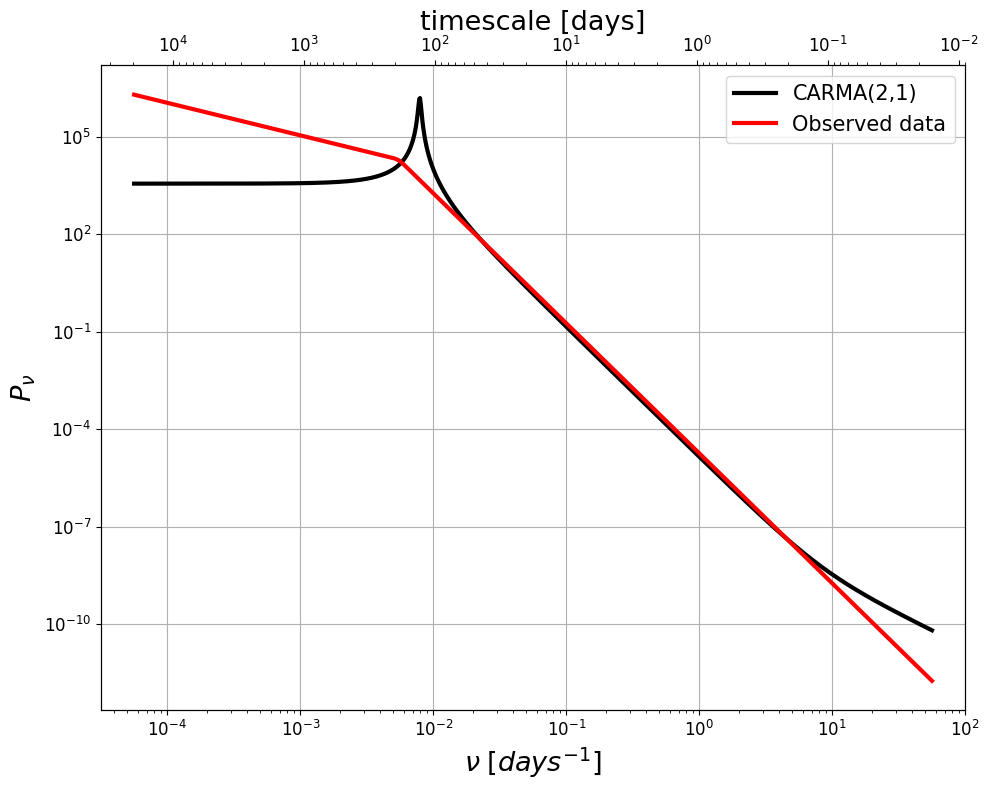

In [ ]:
freq = np.logspace(-4.25,1.75,1000)
spectrum_OBS1 = bend_pl(freq, 20000,  2/365,  -1,-4,10)
p,q = 2,1 # Order of AR and MA that needs to simulated.
psd = []
psd_data = {'freq' : [], 'psd' : []}

for i in range(1): #  plots 100 PSD of CARMA(p,q) using alpha, beta, and sigma drawn from randomly drawn values
    PSD = CARMA_PSD_pq(param_gen(p,q , alpha_range=[-6.1,-6], beta_range=[-3,-2.9],sigma_range = [-3, -2.9]), freq)
    psd_data['freq'] = np.concatenate([psd_data['freq'], freq])
    psd.append(PSD)
    psd_data['psd'] =np.concatenate([psd_data['psd'], PSD])
    # plt.plot(freq , PSD,
    #             'k-', alpha=0.2)

spectrum_CARMA21 =  np.median(psd, axis=0)




fig, ax = plt.subplots(1,1, figsize=[10,8])
#lc = self.sim.simulate(spectrum)
#plt.plot(lc.time/365, lc.counts, 'g')

ax.set_xscale('log')
ax.set_yscale('log')
#ax[0].set_title('Power spectrum', fontsize=16)
ax.set_ylabel(r'$P_{\nu}$', fontsize=19.5)
ax.set_xlabel(r'$\nu\;[days^{-1}]$', fontsize=19.5)
ax.grid()
ax.set_xlim(10**-4.5 , 10**2)
#ax.set_ylim(bottom=10**-9 ,top = 10**5)
ax.tick_params(labelsize=12)
ax_top = ax.twiny()  
ax_top.set_xlabel('timescale [days]', fontsize = 19.5) 
ax_top.plot(1/freq, spectrum_CARMA21,'r-', lw=3, alpha=0.0)
ax_top.set_xscale('log')
ax_top.set_yscale('log')


ax.plot(freq, spectrum_CARMA21,'k-', lw=3, label='CARMA(2,1)')
ax.plot(freq, spectrum_OBS1,'r-', lw=3, label = 'Observed data')

ax_top.tick_params(axis='x', labelsize=12)
ax_top.invert_xaxis()

ax.legend(fontsize=15)
plt.tight_layout()
plt.show()

In [ ]:
from scipy.optimize import least_squares

In [ ]:
freq = np.logspace(-5,2,100)
amps_list = np.logspace(-1,5,10)
sigma_list = np.logspace(-4,3,10)

In [ ]:
def f4(freq, amp, sigma):
    return amp * 1/(1+(freq/sigma)**4)

def sum_f4(n, freq, amps, sigmas):

    total = 0
    for i in range(n):
        total += f4(freq, amps[i], sigmas[i])
    return total
    

(0.0001, 100)

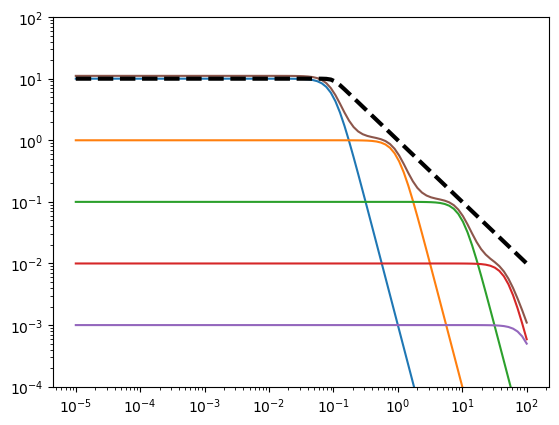

In [ ]:
plt.plot(freq, f4(freq, 10, .100 ))
plt.plot(freq, f4(freq, 1, 1 ))
plt.plot(freq, f4(freq, 0.1, 10 ))
plt.plot(freq, f4(freq, 0.01, 50 ))
plt.plot(freq, f4(freq, 0.001, 100 ))

plt.plot(freq, f4(freq, 10, .100 ) + 
                f4(freq, 1, 1 )+ 
                f4(freq, 0.1, 10 )+ 
                f4(freq, 0.01, 50 )+ 
                f4(freq, 0.001, 100 ))
plt.xscale('log')
plt.yscale('log')

spectrum_OBS1 = bend_pl(freq, 10,  0.1,  -0,-1,10)
plt.plot(freq, spectrum_OBS1,'k--', lw=3, label = 'Observed data')

plt.ylim(0.0001, 100)

In [ ]:
np.random.seed()
rand =  13137 # np.random.randint(0, 100000)
print(rand)
l = LightCurveSampler(N=2**21, rms=0.15, simulatorSEED= rand , verbose=False)
#l.load_powerspec(bend_pl, [200,  0.5/365,  -1,-3,10,], plot=False)
l.load_powerspec(bend_pl_lorentz, [200,  1/365,  -1,-2.5,10, 1, 1/365, 100], plot=False)

l.LCsimulator()
np.random.seed() 
rand =  np.random.randint(0, 100000)

print(rand)
simTIME, simLC, simLCerr , lc = l.sampler(NightsperWINDOW = 20, NumofWINDOW = 10 , OBSperiod = 6, WINDOWwidth =60, samplerSEED=rand,
                                        dataLOSSfrac=0.2, noiseSIGMA=0.015, plot=False)


13137
95817


In [ ]:
def moving_average_interpolated(data, window_size):
        moving_averages = []

        for i in range(len(data) - window_size + 1):
            window = data[i:i + window_size]
            average = sum(window) / window_size
            moving_averages.append(average)

        # Interpolate to match the input data size
        interpolated_moving_averages = np.interp(
            range(len(data)),
            range(window_size - 1, len(data)),
            moving_averages
        )

        return interpolated_moving_averages

In [ ]:
simTIME, simLC, simLCerr = np.loadtxt('AGNobsdata/graham2015data.txt').T

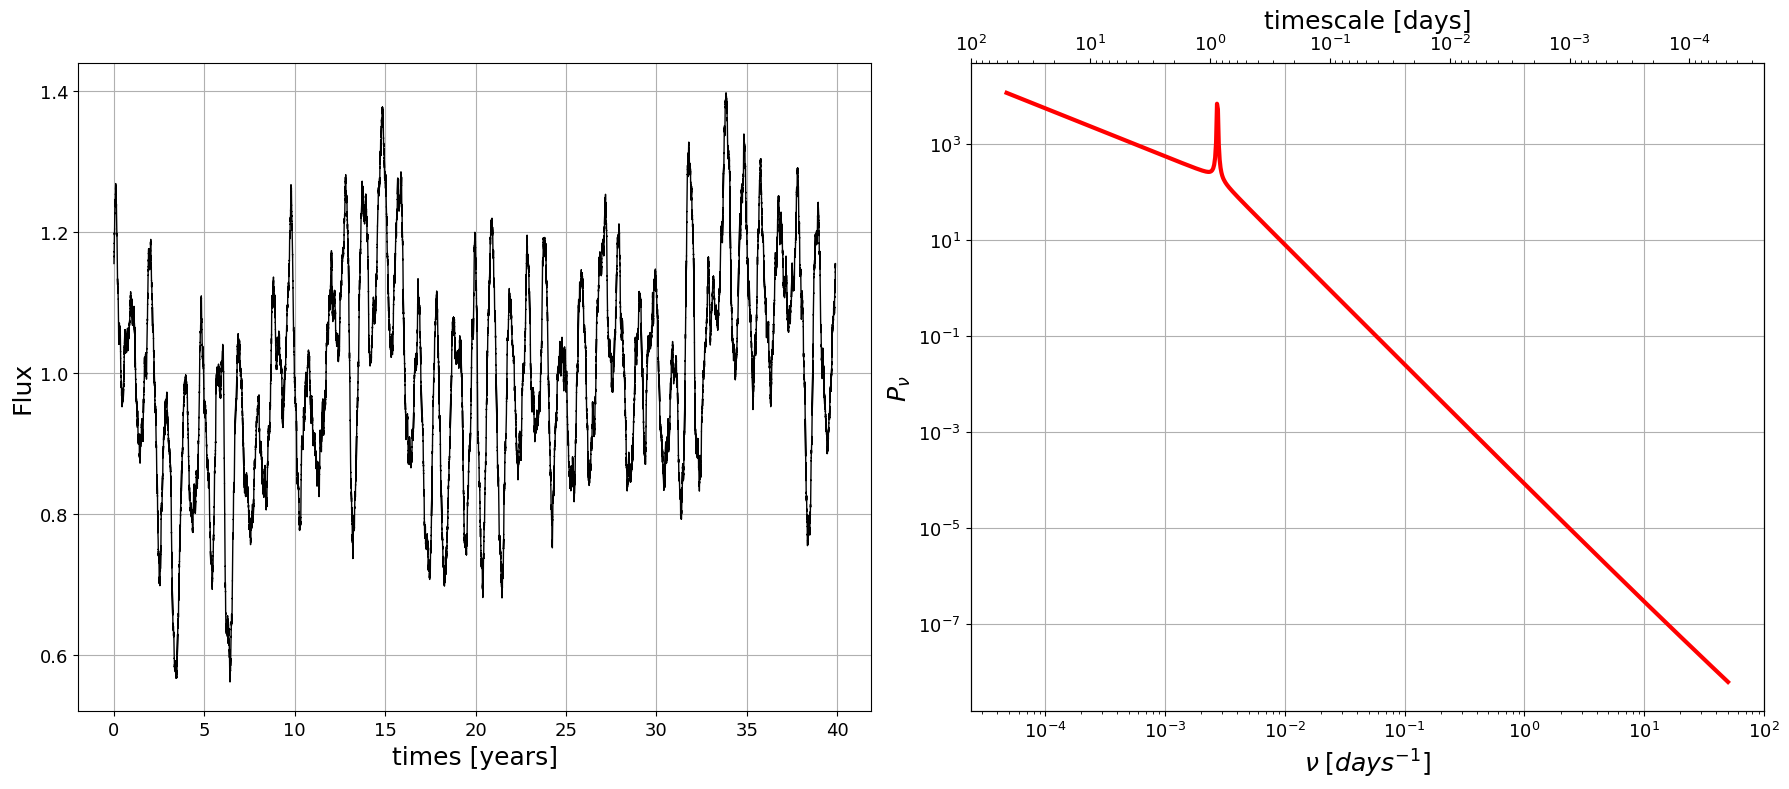

In [ ]:
freq = np.fft.rfftfreq(int(np.power(2, 21)), d=0.01)[1:]   # [1:] to remove the DC power in the spectrum
spectrum_DRW = bend_pl_lorentz(freq, 200,  1/365,  -1,-2.5, 10,  1, 1/365, 100)
#spectrum_DRW = bend_pl(freq, 0.2,  1/2/365,  -0.3,-1.2,10,)
fig, [ax2,ax] = plt.subplots(1,2, figsize=[18,8])
#lc = self.sim.simulate(spectrum)
#plt.plot(lc.time/365, lc.counts, 'g')

ax.set_xscale('log')
ax.set_yscale('log')
#ax[0].set_title('Power spectrum', fontsize=16)
ax.set_ylabel(r'$P_{\nu}$', fontsize=18)
ax.set_xlabel(r'$\nu\;[days^{-1}]$', fontsize=18)
ax.grid()
#ax.set_ylim(bottom=10**-3 ,top = 10**0)
ax.tick_params(labelsize=13)
ax_top = ax.twiny()  
ax_top.set_xlabel('timescale [days]', fontsize = 18) 

plot_freq, plot_spec = LombScargle(simTIME, simLC).autopower(nyquist_factor=3)

ax_top.plot(freq, spectrum_DRW,'k-', lw=1, alpha=0.0)
ax_top.set_xscale('log')
ax_top.set_yscale('log')
#ax.plot(plot_freq/365, moving_average_interpolated(plot_spec, 8),'k.-', lw=1)
ax.plot(freq, spectrum_DRW,'r-', lw=3)
ax_top.tick_params(axis='x', labelsize=13)
ax_top.invert_xaxis()

#ax2.errorbar(lc.time, simLC, yerr = simLCerr, fmt = '.', color ='k', lw =1)
ax2.plot(lc.time/365, lc.counts, 'k-', lw = 1)
ax2.set_ylabel(r'Flux', fontsize=18)
ax2.set_xlabel(r'times [years]', fontsize=18)
ax2.grid()
ax2.tick_params(labelsize=13)

#ax2.plot(simTIME*365, simLC, 'b.')
#ax2.errorbar(simTIME*326, simLC, yerr=simLCerr, fmt = '.', color='b')
#ax.cla()
#ax2.plot(simTIME*365, simLC,'b.')
#ax2.set_ylim(0.55, 1.35)

plt.tight_layout()
plt.savefig('plots/LC_sim_1.png')
plt.show()

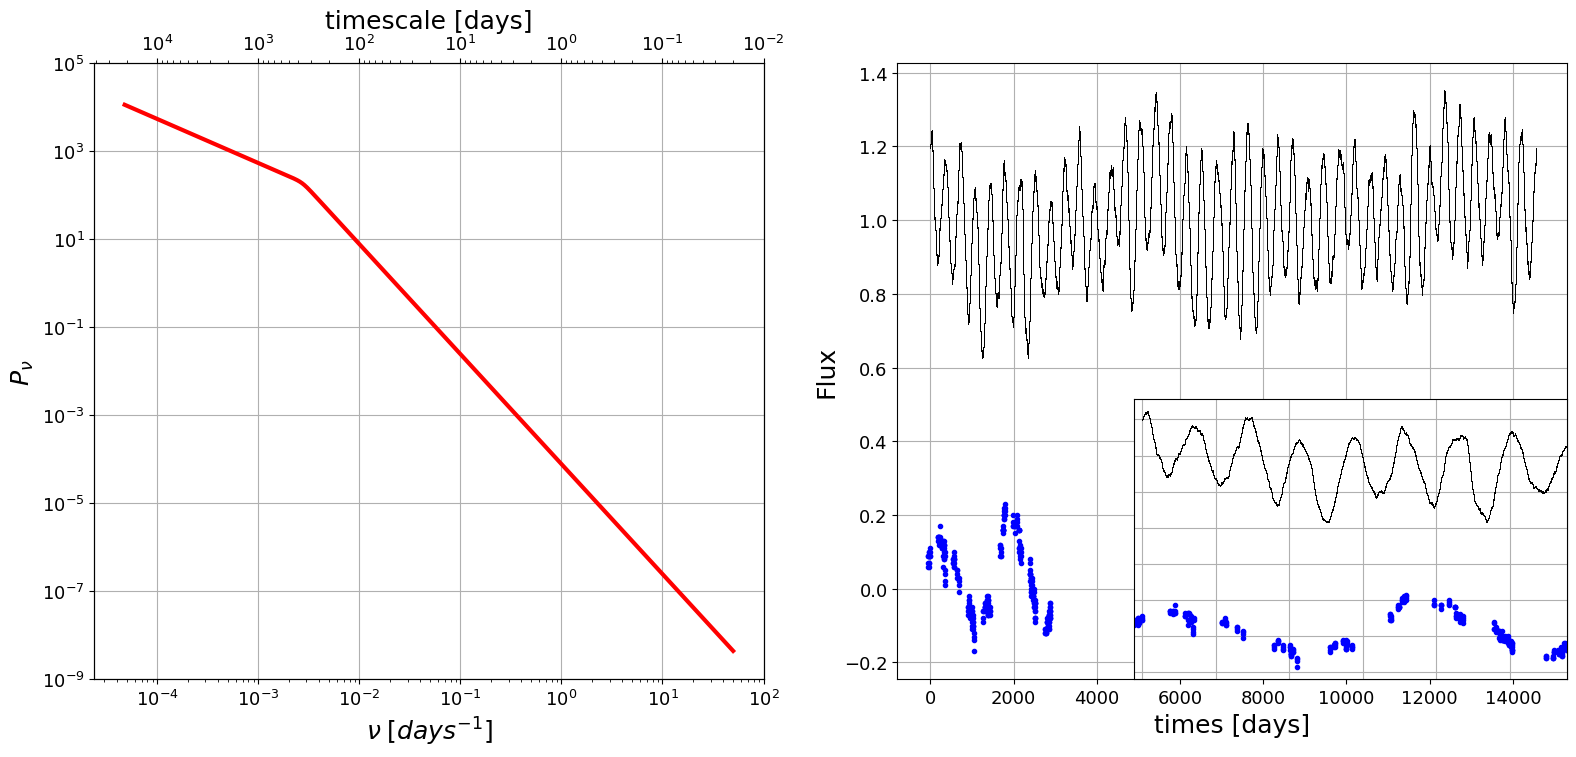

In [ ]:
freq = np.fft.rfftfreq(2**21, d=0.01)[1:]   # [1:] to remove the DC power in the spectrum
spectrum_DRW = bend_pl(freq, 200,  1/365,  -1,-2.5,10)

#fig, [ax,ax2] = plt.subplots(1,2, figsize=[18,8])
#lc = self.sim.simulate(spectrum)
#plt.plot(lc.time/365, lc.counts, 'g')
fig = plt.figure(figsize=[19,8])
ax = fig.add_subplot(121)

ax.set_xscale('log')
ax.set_yscale('log')
#ax[0].set_title('Power spectrum', fontsize=16)
ax.set_ylabel(r'$P_{\nu}$', fontsize=18)
ax.set_xlabel(r'$\nu\;[days^{-1}]$', fontsize=18)
ax.grid()
ax.set_ylim(bottom=10**-9 ,top = 10**5)
ax.tick_params(labelsize=13)
ax_top = ax.twiny()  
ax_top.set_xlabel('timescale [days]', fontsize = 18) 
ax_top.plot(1/freq, spectrum_DRW,'r-', lw=3, alpha=0.0)
ax_top.set_xscale('log')
ax_top.set_yscale('log')
ax.plot(freq, spectrum_DRW,'r-', lw=3)
ax_top.tick_params(axis='x', labelsize=13)
ax_top.invert_xaxis()


ax2 = fig.add_subplot(122)
ax2.plot(lc.time, lc.counts, 'k,')
ax2.set_ylabel(r'Flux', fontsize=18)
ax2.set_xlabel(r'times [days]', fontsize=18)
ax2.grid()
ax2.tick_params(labelsize=13)
ax2.plot(simTIME*365, simLC, 'b.')

#ax2.errorbar(simTIME*326, simLC, yerr=simLCerr, fmt = '.', color='b')
#ax.cla()
#ax2.plot(simTIME*365, simLC,'b.')
# ax2.set_ylim(0.55, 1.35)

ax_small = fig.add_subplot(236)
ax_small.plot(lc.time[(lc.time>simTIME[0]*365) & (lc.time<simTIME[-1]*365)], lc.counts[(lc.time>simTIME[0]*365) & (lc.time<simTIME[-1]*365)], 'k,')
ax_small.plot(simTIME*365, simLC, 'b.')
ax_small.tick_params(axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,
    left = False,
    labelleft = False,
    labelbottom=False)
ax_small.grid()
ax_small.set_xlim(simTIME[0]*365,  simTIME[-1]*365)
plt.tight_layout()
#plt.savefig('PhDpresentation/LC_sim_comb.png')
plt.show()

In [ ]:
simDATA = pd.read_csv('simDATAcsvs/simDATA_highALPHA_2_4.csv')

In [ ]:
simDATA_cropped = simDATA.iloc[0:1000]

In [ ]:
simDATA_cropped[['bestMODEL']] = 'None'
for i,row in simDATA_cropped.iterrows():
    model_list = ['DRW', 'DRWsine', 'CARMA21']
    best_model_arg = np.argmax(np.array(simDATA_cropped.iloc[i][['DRW_log_Z_mean', 'DRWsine_log_Z_mean', 'CARMA21_log_Z_mean']]))
    
    simDATA_cropped.loc[simDATA_cropped.ID == row.ID, 'bestMODEL'] = model_list[best_model_arg]
    print(i, end='-->')

0-->1-->2-->3-->4-->5-->6-->7-->8-->9-->10-->11-->12-->13-->14-->15-->16-->17-->18-->19-->20-->21-->22-->23-->24-->25-->26-->27-->28-->29-->30-->31-->32-->33-->34-->35-->36-->37-->38-->39-->40-->41-->42-->43-->44-->45-->46-->47-->48-->49-->50-->51-->52-->53-->54-->55-->56-->57-->58-->59-->60-->61-->62-->63-->64-->65-->66-->67-->68-->69-->70-->71-->72-->73-->74-->75-->76-->77-->78-->79-->80-->81-->82-->83-->84-->85-->86-->87-->88-->89-->90-->91-->92-->93-->94-->95-->96-->97-->98-->99-->100-->101-->102-->103-->104-->105-->106-->107-->108-->109-->110-->111-->112-->113-->114-->115-->116-->117-->118-->119-->120-->121-->122-->123-->124-->125-->126-->127-->128-->129-->130-->131-->132-->133-->134-->135-->136-->137-->138-->139-->140-->141-->142-->143-->144-->145-->146-->147-->148-->149-->150-->151-->152-->153-->154-->155-->156-->157-->158-->159-->160-->161-->162-->163-->164-->165-->166-->167-->168-->169-->170-->171-->172-->173-->174-->175-->176-->177-->178-->179-->180-->181-->182-->183-->184-->

In [ ]:
for i,row in simDATA_cropped.iterrows():
    model_list = ['DRW', 'DRWsine', 'CARMA21']
    best_model_arg = np.argmax(np.array(simDATA_cropped.iloc[i][['DRW_log_Z_mean', 'DRWsine_log_Z_mean', 'CARMA21_log_Z_mean']]))
    
    simDATA_cropped.loc[simDATA_cropped.ID == row.ID, 'bestMODEL'] = model_list[best_model_arg]
    print(i, end='-->')

0-->1-->2-->3-->4-->5-->6-->7-->8-->9-->10-->11-->12-->13-->14-->15-->16-->17-->18-->19-->20-->21-->22-->23-->24-->25-->26-->27-->28-->29-->30-->31-->32-->33-->34-->35-->36-->37-->38-->39-->40-->41-->42-->43-->44-->45-->46-->47-->48-->49-->50-->51-->52-->53-->54-->55-->56-->57-->58-->59-->60-->61-->62-->63-->64-->65-->66-->67-->68-->69-->70-->71-->72-->73-->74-->75-->76-->77-->78-->79-->80-->81-->82-->83-->84-->85-->86-->87-->88-->89-->90-->91-->92-->93-->94-->95-->96-->97-->98-->99-->100-->101-->102-->103-->104-->105-->106-->107-->108-->109-->110-->111-->112-->113-->114-->115-->116-->117-->118-->119-->120-->121-->122-->123-->124-->125-->126-->127-->128-->129-->130-->131-->132-->133-->134-->135-->136-->137-->138-->139-->140-->141-->142-->143-->144-->145-->146-->147-->148-->149-->150-->151-->152-->153-->154-->155-->156-->157-->158-->159-->160-->161-->162-->163-->164-->165-->166-->167-->168-->169-->170-->171-->172-->173-->174-->175-->176-->177-->178-->179-->180-->181-->182-->183-->184-->

In [ ]:
simDATA_cropped['DRW_CARMA21_diff'] = simDATA_cropped.DRW_log_Z_mean - simDATA_cropped.CARMA21_log_Z_mean
simDATA_cropped['DRWsine_CARMA21_diff'] = simDATA_cropped.DRWsine_log_Z_mean - simDATA_cropped.CARMA21_log_Z_mean

In [ ]:
bestMODELcounts = simDATA_cropped.groupby('highalpha')[['bestMODEL']].value_counts()
BMCdict = bestMODELcounts.to_dict()

highalpha_array = []
DRW_value_counts = []
DRWsine_value_counts = []
for key in BMCdict:
    
    if key[1]=='DRW':
        highalpha_array.append(key[0])
        DRW_value_counts.append(BMCdict[key])
    if key[1]=='DRWsine':
        DRWsine_value_counts.append(BMCdict[key])

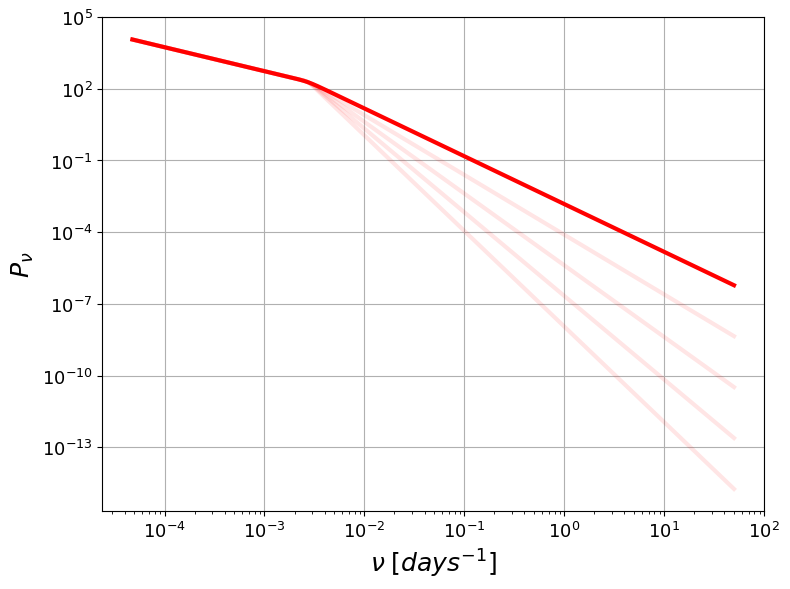

In [ ]:

fig, ax = plt.subplots(1,1,figsize=[8, 6])
# ax[1].barh(np.round(highalpha_array,decimals=2).astype('str'), DRW_value_counts, height=0.5, color='darkblue' )
# ax[1].barh(np.round(highalpha_array,decimals=2).astype('str'), DRWsine_value_counts, left=DRW_value_counts, height=0.5,  color='orange')

# ax[1].legend(['DRW', 'DRW + sine'], fontsize=13)
# ax[1].set_ylabel('High frequency slope', fontsize=15)
# ax[1].set_xlabel('best model percentage', fontsize=15)
# ax[1].invert_yaxis()
# ax[1].tick_params(labelsize=14)


freq = np.fft.rfftfreq(2**21, d=0.01)[1:]   # [1:] to remove the DC power in the spectrum
spectrum_DRW = bend_pl(freq, 200,  1/365,  -1,-4,10)
spectrum_1 = bend_pl(freq, 200,  1/365,  -1,-3.5,10)
spectrum_2 = bend_pl(freq, 200,  1/365,  -1,-3,10)
spectrum_3 = bend_pl(freq, 200,  1/365,  -1,-2.5,10)
spectrum_4 = bend_pl(freq, 200,  1/365,  -1,-2,10)


ax.set_xscale('log')
ax.set_yscale('log')
#ax[0].set_title('Power spectrum', fontsize=16)
ax.set_ylabel(r'$P_{\nu}$', fontsize=18)
ax.set_xlabel(r'$\nu\;[days^{-1}]$', fontsize=18)
ax.grid()
#ax[1].set_ylim(bottom=10**-9 ,top = 10**5)
ax.tick_params(labelsize=13)
#ax_top = ax[1].twiny()  
#ax_top.set_xlabel('timescale [days]', fontsize = 18) 
#ax_top.plot(1/freq, spectrum_DRW,'r-', lw=3, alpha=0.0)
#ax_top.set_xscale('log')
#ax_top.set_yscale('log')
ax.plot(freq, spectrum_DRW,'r-', lw=3, alpha=0.1)
ax.plot(freq, spectrum_1,'r-', lw=3, alpha=0.1)
ax.plot(freq, spectrum_2,'r-', lw=3, alpha=0.1)
ax.plot(freq, spectrum_3,'r-', lw=3, alpha=0.1)
ax.plot(freq, spectrum_4,'r-', lw=3, alpha=1)
#ax_top.tick_params(axis='x', labelsize=13)
#ax_top.invert_xaxis()


plt.tight_layout()
#plt.savefig('PhDpresentation/barGraph.png')
plt.show()